In [1]:
from brian2 import *

prefs.codegen.target = "numpy"

WARNING    /var/folders/dk/88m9s1b50v53bxqm50d17bjm0000gp/T/ipykernel_25412/1471473820.py:10: RuntimeWarning: invalid value encountered in power
  ttm = 0.1092 * exp(-0.5 * ((vv + 28.71)/25.5)**1.8)
 [py.warnings]


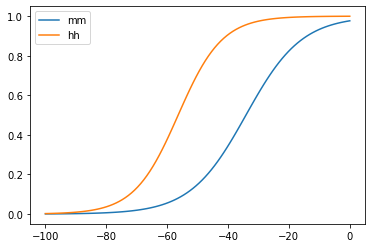

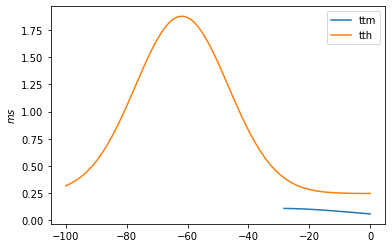

In [15]:
vv = linspace(-100, 0, 100)
mm = 1/(1 + exp((-34.12 - vv)/9.146))
hh = 1/(1 + exp((-56.39 - vv)/7.22))


plot(vv, mm, label='mm')
plot(vv, hh, label='hh')
legend()

ttm = 0.1092 * exp(-0.5 * ((vv + 28.71)/25.5)**1.8)
tth = 0.246 + 1.63 * exp(-0.5 * ((vv + 61.87)/15.25)**2)

figure()
plot(vv, ttm, label='ttm')
plot(vv, tth, label='tth')
ylabel("$ms$")
legend()

In [19]:
start_scope()

# morphology creation
cyl_len = 50 * umetre
cyl_diam = 50 * umetre
cylinder = Cylinder(length=cyl_len, diameter=cyl_diam, n=1, type="axon")

# consta and parameters
Cm = 1 * ufarad / cm**2
Eleak = -65.5 * mV
Vr = -57.4 * mV
gl = 1.42 * msiemens/cm**2
q10 = 3 ** ((20 - 6.3)/10)  # 20 stands for degree Celsius

gNa_f_max = 25 * msiemens/cm**2
gNa_l1_max = 27 * msiemens/cm**2
#gNa_l2_max = pass

ENa = 62 * mV

# equations

main_eq = """
Im = gl * (Eleak - v) + INa_f + INa_l1 : amp/meter**2
I : amp (point current)
"""

Na_f_eq = """
INa_f = gNa_f_max * m_f**3 * h_f * (ENa - v) : ampere/meter**2

dm_f/dt = (m_f_inf - m_f) / tau_m_f : 1
m_f_inf = 1 / (1 + exp((v12m - v)/slope_m)) : 1
tau_m_f = 1*ms / (q10 * (alpha_m + beta_m)) : second  # modelDB version
alpha_m = 1 / exprel(-(v + 34*mV)/10/mV) : 1
beta_m = 4 * exp(-(v + 59*mV)/18/mV) : 1

dh_f/dt = (h_f_inf - h_f) / tau_h_f : 1
h_f_inf = 1 / (1 + exp((v12h - v)/slope_h)) : 1
tau_h_f = 0.246*ms + 1.63*ms * exp(-0.5 * ((v + 61.87*mV)/15.25/mV)**2) : second
"""

Na_l1_eq = """
INa_l1 = gNa_l1_max * m_l1 * h_l1 * (ENa - v) : ampere/meter**2

alpha_m_l1 = 1 / exprel(-(v + 25*mV)/10/mV) : 1
beta_m_l1 = 4 * exp(-(v + 50*mV)/18/mV) : 1
m_l1 = alpha_m_l1 / (alpha_m_l1 + beta_m_l1) : 1

dh_l1/dt = (h_l1_inf - h_l1) / tau_h_l1 : 1
h_l1_inf = 1 / (1 + exp((v12h - v)/slope_h)) : 1
tau_h_l1 = 0.2218*ms * exp(-0.06883*v/mV) : second
"""
Na_l1_eq = Equations(Na_l1_eq,
                     v12m=-25.9*mV,
                     slope_m=9.052*mV,
                     v12h=-72.5*mV,
                     slope_h=8.*mV)
Na_l2_eq = """
INa_l2 = gNa_l2_max * m_l2**3 * h_l2 * (ENa - v) : ampere/meter**2



"""

Na_f_eq = Equations(Na_f_eq,
                    v12m=-34.12*mV,
                    v12h=-56.39*mV,
                    slope_m=9.146*mV,
                    slope_h=7.22*mV)
#l1Na_eq = Equations(pass)
#l2Na_eq = Equations(pass)

main_eq = Equations(main_eq) + Na_f_eq + Na_l1_eq


# neuron main object
neuron = SpatialNeuron(morphology=cylinder,
                    model=main_eq, Cm=Cm, Ri=35.4*ohm*cm,
                    method="exponential_euler")

# monitors
mon = StateMonitor(neuron, ['v', "m_l1", "m_f_inf"], record=True)

neuron.v = -70*mV

run(50*ms)
neuron.I = .55 * nA
run(25*ms)
neuron.I = 0*nA
run(50*ms)

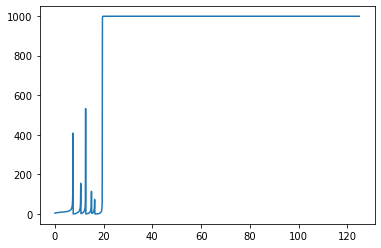

In [17]:
plot(mon.t/ms, mon.m_l1[0]/mV)

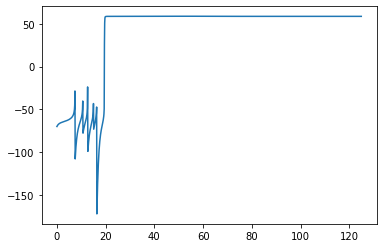

In [18]:
# result plots
plot(mon.t/ms, mon.v[0]/mV)